In [1]:
# Install necessary libraries
!pip install numpy pandas librosa mediapipe opencv-python transformers matplotlib scikit-learn tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 42.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import librosa
import mediapipe as mp
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Multiply, Lambda, Concatenate, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict
import math
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2


In [3]:
# --- AUDIO PREPROCESSING ---
def augment_audio(y, sr):
    noise = np.random.normal(0, 0.005, y.shape)  # Add random noise
    y_stretch = librosa.effects.time_stretch(y, rate=0.9)  # Time stretch
    y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Pitch shift
    return [y, y + noise, y_stretch, y_shift]

def preprocess_audio_with_augmentation(audio_dir):
    mfccs, labels = [], []
    for folder in os.listdir(audio_dir):
        folder_path = os.path.join(audio_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                audio_path = os.path.join(folder_path, file)
                y, sr = librosa.load(audio_path, sr=None)
                augmented_audios = augment_audio(y, sr)  # Apply augmentations
                for augmented_audio in augmented_audios:
                    mfcc = librosa.feature.mfcc(y=augmented_audio, sr=sr, n_mfcc=13)
                    delta_mfcc = librosa.feature.delta(mfcc)
                    combined_mfcc = np.concatenate([mfcc, delta_mfcc], axis=0)
                    mfccs.append(np.mean(combined_mfcc.T, axis=0))
                    labels.append(folder)  # Append the same label for augmented data
    return np.array(mfccs), np.array(labels)

speech_data_path = '/kaggle/input/ravdess-emotional-speech-audio'
audio_features, audio_labels = preprocess_audio_with_augmentation(speech_data_path)

In [4]:
# --- FACIAL PREPROCESSING ---
def augment_image(image):
    flipped = cv2.flip(image, 1)  # Horizontal flip
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=50)  # Brightness adjustment
    return [image, flipped, bright]

def preprocess_facial_data_with_augmentation(image_dir):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    features, labels = [], []
    for folder in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith(('.jpg', '.png')):
                img_path = os.path.join(folder_path, file)
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                augmented_images = augment_image(img_rgb)  # Apply augmentations
                for aug_img in augmented_images:
                    results = face_mesh.process(aug_img)
                    if results.multi_face_landmarks:
                        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.multi_face_landmarks[0].landmark]).flatten()
                    else:
                        landmarks = np.zeros(468 * 3)  # Zero vector if no landmarks detected
                    features.append(landmarks)
                    labels.append(folder)  # Append the same label for augmented data
    return np.array(features), np.array(labels)

facial_data_path = '/kaggle/input/fer2013'
facial_features, facial_labels = preprocess_facial_data_with_augmentation(facial_data_path)



In [5]:
# --- BODY GESTURE PREPROCESSING ---
def augment_body_landmarks(landmarks):
    # Rotate landmarks by a small angle (synthetic augmentation)
    rotation_matrix = np.array([[0.99, -0.1, 0], [0.1, 0.99, 0], [0, 0, 1]])  # Slight rotation
    rotated_landmarks = np.dot(landmarks, rotation_matrix)
    return [landmarks, rotated_landmarks]

def preprocess_body_data_with_augmentation(pkl_dir):
    body_features, labels = [], []
    for file in os.listdir(pkl_dir):
        if file.endswith('.pkl'):
            pkl_path = os.path.join(pkl_dir, file)
            with open(pkl_path, 'rb') as f:
                data = pickle.load(f)
            if 'pose_landmarks' in data:
                landmarks = np.array(data['pose_landmarks'])
                augmented_landmarks = augment_body_landmarks(landmarks)
                for aug_landmark in augmented_landmarks:
                    body_features.append(aug_landmark.flatten())
                    labels.append(os.path.splitext(file)[0])  # Append same label
    return np.array(body_features), np.array(labels)

# Preprocess body gesture data
body_data_path = '/kaggle/input/skeleton-data-of-ntu-rgbd-60-dataset'
body_features, body_labels = preprocess_body_data_with_augmentation(body_data_path)


In [6]:
from transformers import BertTokenizer
import pandas as pd
import os 

def preprocess_text(text_file):
    # Specify the column names based on the file structure
    column_names = ['target', 'id', 'date', 'query', 'user', 'text']
    # Find the CSV file within the directory
    for filename in os.listdir(text_file):
        if filename.endswith('.csv'):
            csv_file_path = os.path.join(text_file, filename)
            break  # Stop searching after finding the first CSV file
    else:
        raise FileNotFoundError("No CSV file found in the directory.")
    
    # Read the CSV file
    df = pd.read_csv(csv_file_path, encoding='latin-1', names=column_names)

    # Extract relevant columns
    texts = df['text'].fillna('')  # Fill missing text with empty strings
    labels = df['target'].values  # Sentiment labels

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the text data
    tokenized = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='np')

    return tokenized['input_ids'], tokenized['attention_mask'], labels

text_data_path = '/kaggle/input/sentiment140'
text_inputs, text_masks, text_labels = preprocess_text(text_data_path)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# --- FEATURE STANDARDIZATION ---
scaler = StandardScaler()
if facial_features.ndim == 1:
    if facial_features.size == 0:
        facial_features = np.zeros((1, 1))  # Add a dummy sample
    else:
        facial_features = facial_features.reshape(-1, 1)
facial_features = scaler.fit_transform(facial_features)

scaler = StandardScaler()
if body_features.ndim == 1:
    if body_features.size == 0:
        body_features = np.zeros((1, 1))  # Add a dummy sample
    else:
        body_features = body_features.reshape(-1, 1)
body_features = scaler.fit_transform(body_features)

# --- STANDARDIZATION ---
scaler = StandardScaler()
audio_features = scaler.fit_transform(audio_features)
facial_features = scaler.fit_transform(facial_features)
body_features = scaler.fit_transform(body_features)
text_features = scaler.fit_transform(text_labels.reshape(-1, 1))


In [8]:
# --- RELIABILITY CALCULATION ---
def calculate_reliability(signal, noise=None):
    if noise is None:
        noise = np.random.normal(0, 0.1, signal.shape)
    return np.std(signal, axis=0) / (np.std(noise, axis=0) + 1e-9)

audio_reliability = calculate_reliability(audio_features)
facial_reliability = calculate_reliability(facial_features)
body_reliability = calculate_reliability(body_features)
text_reliability = calculate_reliability(text_features)

# Adjust reliabilities for context
context_vector = np.array([1.0, 0.9, 0.8, 1.1])
adjusted_reliabilities = np.array([audio_reliability.mean(), facial_reliability.mean(), body_reliability.mean(), text_reliability.mean()]) * context_vector

# --- DYNAMIC EMOTIONAL UNCERTAINTY QUANTIFICATION ---
def shannon_entropy(probabilities):
    """
    Calculate Shannon entropy for a probability distribution
    H(X) = -sum(P(x) * log(P(x)))
    """
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def calculate_uncertainty(predictions):
    """
    Calculate emotional uncertainty from model predictions using Shannon entropy
    Higher entropy means higher uncertainty
    """
    entropy_values = np.apply_along_axis(shannon_entropy, 1, predictions)
    # Normalize to [0, 1] range
    max_entropy = -np.log2(1/predictions.shape[1])  # Maximum possible entropy
    normalized_entropy = entropy_values / max_entropy
    return normalized_entropy

def weighted_modality_uncertainty(modality_predictions, reliabilities):
    """
    Calculate uncertainty for each modality, weighted by reliability
    """
    modality_entropies = [calculate_uncertainty(preds) for preds in modality_predictions]
    # Weight entropies by inverse reliability (higher reliability → lower entropy contribution)
    reliability_weights = 1 - (reliabilities / np.sum(reliabilities))
    weighted_entropies = np.sum([w * e for w, e in zip(reliability_weights, modality_entropies)], axis=0)
    return weighted_entropies

# --- RESONANCE MAPPING FUNCTION ---
def resonance_mapping(v0, v_user, alpha=0.1, uncertainty=None):
    """
    Calculate resonance between goal state and user state, with uncertainty penalty
    
    Parameters:
    v0: Goal state vector
    v_user: Current user state vector
    alpha: Misalignment penalty factor
    uncertainty: Uncertainty value (optional)
    
    Returns:
    Resonance score
    """
    # Calculate alignment score (cosine similarity)
    alignment_score = np.dot(v0, v_user) / (np.linalg.norm(v0) * np.linalg.norm(v_user) + 1e-9)
    
    # Calculate misalignment penalty
    misalignment_penalty = alpha * (1 - alignment_score)
    
    # Include uncertainty effect if provided
    if uncertainty is not None:
        # Higher uncertainty decreases resonance
        uncertainty_penalty = np.mean(uncertainty) * 0.2
        return alignment_score - misalignment_penalty - uncertainty_penalty
    
    return alignment_score - misalignment_penalty

# --- TEMPORAL EMOTIONAL PREDICTION ---
def learn_state_transition_matrix(y_train):
    """
    Learn state transition probabilities from training data
    P(E_t+1 | E_t)
    """
    transition_matrix = defaultdict(lambda: defaultdict(int))
    unique_states = np.unique(y_train)
    
    # Count transitions
    for i in range(len(y_train) - 1):
        current_state = y_train[i]
        next_state = y_train[i + 1]
        transition_matrix[current_state][next_state] += 1
    
    # Normalize to probabilities
    probability_matrix = {}
    for s in unique_states:
        total = sum(transition_matrix[s].values())
        if total > 0:
            probability_matrix[s] = {t: transition_matrix[s][t] / total for t in unique_states}
        else:
            # If no transitions from this state, assume uniform distribution
            probability_matrix[s] = {t: 1/len(unique_states) for t in unique_states}
    
    return probability_matrix

def predict_next_emotional_state(current_state, transition_matrix, model_prediction=None, alpha=0.7):
    """
    Predict next emotional state based on current state and model prediction
    E(t+1) = alpha * E(t) + (1-alpha) * delta(E)
    
    Parameters:
    current_state: Current emotional state
    transition_matrix: State transition probability matrix
    model_prediction: Neural model's prediction (optional)
    alpha: Weighting factor for history vs. new prediction
    
    Returns:
    Predicted next state probability distribution
    """
    # Get transition probabilities from current state
    state_transition_probs = np.array([transition_matrix[current_state].get(s, 0) for s in sorted(transition_matrix[current_state].keys())])
    
    if model_prediction is None:
        return state_transition_probs
    
    # Combine historical transitions with model prediction
    combined_prediction = alpha * state_transition_probs + (1 - alpha) * model_prediction
    # Normalize to ensure valid probability distribution
    return combined_prediction / np.sum(combined_prediction)

In [9]:
# --- CUSTOM LOSS FUNCTION WITH RESONANCE AND UNCERTAINTY ---
def cognitive_resonance_loss(lambda_val=0.2):
    """
    Custom loss function combining resonance misalignment and uncertainty
    Loss = -Mres + lambda * Ue
    
    Parameters:
    lambda_val: Weight for uncertainty term
    
    Returns:
    Loss function
    """
    def loss_function(y_true, y_pred):
        import tensorflow as tf
        
        # One-hot encode y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        
        # Calculate focal loss component
        gamma = 2.0
        alpha = 0.25
        y_pred_clipped = tf.clip_by_value(y_pred, 1e-9, 1.0 - 1e-9)
        focal_loss_val = -y_true_one_hot * alpha * tf.pow(1 - y_pred_clipped, gamma) * tf.math.log(y_pred_clipped)
        focal_loss_val = tf.reduce_sum(focal_loss_val, axis=1)
        
        # Calculate Shannon entropy (uncertainty)
        entropy = -tf.reduce_sum(y_pred_clipped * tf.math.log(y_pred_clipped), axis=1)
        max_entropy = tf.math.log(tf.cast(y_pred.shape[-1], tf.float32))
        normalized_entropy = entropy / max_entropy
        
        # Calculate resonance misalignment
        goal_vector = y_true_one_hot
        user_vector = y_pred
        
        # Alignment score (cosine similarity)
        dot_product = tf.reduce_sum(goal_vector * user_vector, axis=1)
        goal_norm = tf.sqrt(tf.reduce_sum(tf.square(goal_vector), axis=1))
        user_norm = tf.sqrt(tf.reduce_sum(tf.square(user_vector), axis=1))
        alignment_score = dot_product / (goal_norm * user_norm + 1e-9)
        
        # Misalignment penalty
        alpha_penalty = 0.1
        misalignment_penalty = alpha_penalty * (1 - alignment_score)
        
        # Resonance score
        resonance_score = alignment_score - misalignment_penalty
        
        # Combined loss: -resonance + lambda * uncertainty + focal_loss
        combined_loss = -resonance_score + lambda_val * normalized_entropy + focal_loss_val
        
        return tf.reduce_mean(combined_loss)
    
    return loss_function

# --- FUSION ---
def align_features(features):
    max_samples = max(f.shape[0] for f in features)
    max_features = max(f.shape[1] for f in features)
    aligned = [np.pad(f, ((0, max_samples - f.shape[0]), (0, max_features - f.shape[1])), 'constant') for f in features]
    return aligned

def weighted_fusion(features, reliabilities):
    aligned_features = align_features(features)
    weights = reliabilities / np.sum(reliabilities)
    return sum(w * f for w, f in zip(weights, aligned_features))

fused_features = weighted_fusion([audio_features, facial_features, body_features, text_features], adjusted_reliabilities)

# --- ADVANCED MULTIMODAL FUSION CLASS ---
from tensorflow.keras.layers import Layer
import tensorflow as tf
import numpy as np

class DynamicMultimodalFusion(Layer):
    def __init__(self, **kwargs):
        super(DynamicMultimodalFusion, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.reliability_weights = self.add_weight(name='reliability_weights',
                                                   shape=(len(input_shape),),
                                                   initializer='ones',
                                                   trainable=True)
        super(DynamicMultimodalFusion, self).build(input_shape)
        
    def call(self, inputs):
        normalized_weights = tf.nn.softmax(self.reliability_weights)
        weighted_inputs = [normalized_weights[i] * inputs[i] for i in range(len(inputs))]
        fused = tf.add_n(weighted_inputs)
        return fused
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

# --- ATTENTION MECHANISM ---
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(Attention, self).build(input_shape)
    
    def call(self, x):
        scores = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        weights = tf.nn.softmax(tf.tensordot(scores, self.u, axes=1), axis=1)
        output = tf.reduce_sum(x * weights, axis=1)
        return output
    
    def get_config(self):
        config = super(Attention, self).get_config()
        return config

# --- REINFORCEMENT-BASED FEEDBACK MECHANISM ---
from tensorflow.keras.callbacks import Callback

class FeedbackLearningCallback(Callback):
    def __init__(self, X_val, context_val, y_val, model, transition_matrix, alpha=0.7, update_freq=5):
        super(FeedbackLearningCallback, self).__init__()
        self.X_val = X_val
        self.context_val = context_val  # Added context input
        self.y_val = y_val
        self.base_model = model
        self.transition_matrix = transition_matrix
        self.alpha = alpha
        self.update_freq = update_freq
        self.history = []
        self.update_count = 0
    
    def on_epoch_end(self, epoch, logs=None):
        self.update_count += 1
        if self.update_count % self.update_freq != 0:
            return
        
        # Ensure both inputs (features + context) are passed
        predictions = self.base_model.predict([self.X_val, self.context_val])
        emotion_preds, uncertainty_preds = predictions
        
        feedback_dict = {}
        
        for i in range(len(self.X_val)):
            current_state = self.y_val[i]
            prediction = emotion_preds[i]
            
            # Temporal prediction using transition matrix
            temporal_prediction = predict_next_emotional_state(
                current_state, 
                self.transition_matrix,
                prediction,
                self.alpha
            )
            
            uncertainty = uncertainty_preds[i][0]
            
            # Calculate resonance score
            goal_vector = np.zeros(len(prediction))
            goal_vector[current_state] = 1
            resonance = resonance_mapping(goal_vector, prediction, uncertainty=uncertainty)
            
            feedback_dict[i] = {
                'original_prediction': prediction,
                'temporal_prediction': temporal_prediction,
                'uncertainty': uncertainty,
                'resonance': resonance
            }
        
        self.history.append(feedback_dict)
        
        avg_resonance = np.mean([f['resonance'] for f in feedback_dict.values()])
        avg_uncertainty = np.mean([f['uncertainty'] for f in feedback_dict.values()])
        print(f"\nFeedback Learning Update - Avg Resonance: {avg_resonance:.4f}, Avg Uncertainty: {avg_uncertainty:.4f}")

In [10]:
# --- TRAIN TEST SPLIT ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(audio_labels)

X_train, X_test, y_train, y_test = train_test_split(fused_features[:len(y_encoded)], y_encoded, test_size=0.2, random_state=42)

# Learn state transition matrix from training data
transition_matrix = learn_state_transition_matrix(y_train)

# --- CLASS WEIGHTS ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))


In [11]:
# --- BUILD ADVANCED MODEL WITH COGNITIVE RESONANCE COMPONENTS ---
def build_cognitive_resonance_model(input_dim, output_dim):
   # Main input for fused features
    inputs = Input(shape=(input_dim,))
    
    # Context vector input (optional, can be user state, environment, etc.)
    context_input = Input(shape=(output_dim,))
    # Fully Connected Layers with batch normalization
    dense1 = Dense(2048, activation='relu', kernel_regularizer=l2(0.001))(inputs)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn1)
    
    # Integrate context information
    context_dense = Dense(1024, activation='relu')(context_input)
    context_dropout = Dropout(0.3)(context_dense)
    
    # Combine feature path with context
    dense2 = Dense(1024, activation='relu')(dropout1)
    bn2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.4)(bn2)
    
    # Concatenate with context
    merged = Concatenate()([dropout2, context_dropout])
    
    # BiLSTM with Attention for temporal modeling
    lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=(1, 1024 + 1024))(merged)  # Adjust shape to match merged layer size
    bilstm = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(lstm_input)
    attention_output = Attention()(bilstm)

    # Additional dense layers
    dense3 = Dense(512, activation='relu')(attention_output)
    bn3 = BatchNormalization()(dense3)
    dropout3 = Dropout(0.3)(bn3)
    
    # Output layer for emotion classification
    emotion_output = Dense(output_dim, activation='softmax', name='emotion_output')(dropout3)
    
    # Uncertainty estimation branch
    uncertainty_output = Dense(1, activation='sigmoid', name='uncertainty_output')(dropout3)
    
    # Create model with multiple inputs and outputs
    model = Model(inputs=[inputs, context_input], outputs=[emotion_output, uncertainty_output])
    
    # Compile with custom loss function
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'emotion_output': cognitive_resonance_loss(lambda_val=0.2),
            'uncertainty_output': 'mse'
        },
        loss_weights={
            'emotion_output': 1.0,
            'uncertainty_output': 0.5
        },
        metrics={
            'emotion_output': 'accuracy'
        }
    )
    
    return model

# --- PREPARE DATA FOR MULTI-INPUT MODEL ---
# Create dummy context vectors (in real system, this would be actual context data)
num_classes = len(np.unique(y_train))
context_train = np.zeros((X_train.shape[0], num_classes))
context_test = np.zeros((X_test.shape[0], num_classes))

# Create uncertainty targets (in real system, these would be actual uncertainty values)
# For now, we'll use higher uncertainty for samples near decision boundaries
def generate_uncertainty_targets(X, y, model):
    # Train a simple model to get prediction probabilities
    simple_model = tf.keras.Sequential([
        Dense(512, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.4),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    simple_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    simple_model.fit(X, y, epochs=3, verbose=0, batch_size=64)
    
    # Get predictions
    preds = simple_model.predict(X)
    
    # Calculate entropy as uncertainty
    entropies = np.array([shannon_entropy(p) for p in preds])
    
    # Normalize to [0, 1]
    max_entropy = -np.log2(1/num_classes)
    normalized_entropies = entropies / max_entropy
    
    return normalized_entropies.reshape(-1, 1)

# Create a simple model to generate initial uncertainty targets
simple_model = tf.keras.Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])
simple_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
simple_model.fit(X_train, y_train, epochs=2, verbose=0, batch_size=64)

# Generate uncertainty targets
uncertainty_train = generate_uncertainty_targets(X_train, y_train, simple_model)
uncertainty_test = generate_uncertainty_targets(X_test, y_test, simple_model)

# --- MODEL TRAINING WITH FEEDBACK MECHANISM ---
# Initialize the cognitive resonance model
cr_model = build_cognitive_resonance_model(X_train.shape[1], num_classes)
cr_model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_emotion_output_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_emotion_output_loss', patience=10, restore_best_weights=True,mode='min')

# Create validation split for feedback learning
X_train_main, X_val, y_train_main, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
context_train_main, context_val = train_test_split(context_train, test_size=0.1, random_state=42)
uncertainty_train_main, uncertainty_val = train_test_split(uncertainty_train, test_size=0.1, random_state=42)

# Feedback learning callback
feedback_callback = FeedbackLearningCallback(
    X_val=X_val,
    context_val=context_val,  # Ensure context is passed correctly
    y_val=y_val,
    model=cr_model,
    transition_matrix=transition_matrix,
    alpha=0.7,
    update_freq=5
)


# Compute sample weights for the emotion output based on the class weights
emotion_sample_weight = np.array([class_weights_dict[label] for label in y_train_main])
# For the uncertainty output, use uniform weights (all ones)
uncertainty_sample_weight = np.ones(len(emotion_sample_weight))

# Train the model without using class_weight
history = cr_model.fit(
    [X_train_main, context_train_main],  # Ensure both inputs are provided
    {'emotion_output': y_train_main, 'uncertainty_output': uncertainty_train_main},
    sample_weight={
        'emotion_output': emotion_sample_weight,
        'uncertainty_output': uncertainty_sample_weight
    },
    validation_data=(
        [X_val, context_val],  # Both inputs for validation too
        {'emotion_output': y_val, 'uncertainty_output': uncertainty_val}
    ),
    epochs=200,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping, feedback_callback],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 26)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2048)           │         55,296 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ dense_6[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 2048)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1024)           │      2,098,176 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 24)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1024)           │         25,600 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1024)           │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2048)           │              0 │ dropout_5[0][0],       │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 2048)        │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 1, 512)         │      4,720,640 │ lambda[0][0]           │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 512)            │        263,168 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        262,656 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,452,697 (28.43 MB)

 Trainable params: 7,445,529 (28.40 MB)

 Non-trainable params: 7,168 (28.00 KB)

Epoch 1/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - emotion_output_accuracy: 0.1891 - emotion_output_loss: 0.6783 - loss: 0.7830 - uncertainty_output_loss: 0.0517 - val_emotion_output_accuracy: 0.0716 - val_emotion_output_loss: 0.6987 - val_loss: 0.7703 - val_uncertainty_output_loss: 0.0174 - learning_rate: 0.0010
Epoch 2/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - emotion_output_accuracy: 0.4201 - emotion_output_loss: 0.0649 - loss: 0.1424 - uncertainty_output_loss: 0.0215 - val_emotion_output_accuracy: 0.2907 - val_emotion_output_loss: 0.3697 - val_loss: 0.4508 - val_uncertainty_output_loss: 0.0218 - learning_rate: 0.0010
Epoch 3/200
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - emotion_output_accuracy: 0.5158 - emotion_output_loss: -0.1128 - loss: -0.0398 - uncertainty_output_loss: 0.0147 - val_emotion_output_accuracy: 0.5662 - val_emotion_output_loss: -0.2194 - val_loss: -0.1532 - val_uncertainty_output_loss: 0.0130 - learning_rate: 0.0010
Epoch 4/200
130/130 ━━━━━━━━━━━━━━

In [12]:
# Evaluate the model on test data
test_results = cr_model.evaluate(
    [X_test, context_test],
    {'emotion_output': y_test, 'uncertainty_output': uncertainty_test},
    verbose=1
)

print("\n--- Test Results ---")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Emotion Output Loss: {test_results[1]:.4f}")
print(f"Test Uncertainty Output Loss: {test_results[2]:.4f}")
print(f"Test Emotion Classification Accuracy: {test_results[3]:.4f}")

# Compare train and test accuracy
train_accuracy = history.history['emotion_output_accuracy'][-1]
val_accuracy = history.history['val_emotion_output_accuracy'][-1]
test_accuracy = test_results[3]

print("\n--- Accuracy Summary ---")
print(f"Final Train Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - emotion_output_accuracy: 0.8856 - emotion_output_loss: -0.7889 - loss: -0.6760 - uncertainty_output_loss: 0.0386

--- Test Results ---
Test Loss: -0.6694
Test Emotion Output Loss: -0.7813
Test Uncertainty Output Loss: 0.0376
Test Emotion Classification Accuracy: 0.8741

--- Accuracy Summary ---
Final Train Accuracy: 0.9166
Final Validation Accuracy: 0.8937
Test Accuracy: 0.8741


In [13]:
# --- EVALUATION ---
# Evaluate the model
test_results = cr_model.evaluate(
    [X_test, context_test],
    {'emotion_output': y_test, 'uncertainty_output': uncertainty_test},
    verbose=1
)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Emotion Output Loss: {test_results[1]:.4f}")
print(f"Uncertainty Output Loss: {test_results[2]:.4f}")
print(f"Emotion Classification Accuracy: {test_results[3]:.4f}")

# --- PREDICTION WITH TEMPORAL DYNAMICS ---
def predict_with_cognitive_resonance(model, X, context, previous_state=None, transition_matrix=None, alpha=0.7):
    """
    Make predictions with the cognitive resonance model, incorporating temporal dynamics
    if previous state and transition matrix are provided
    """
    # Get raw model predictions
    emotion_pred, uncertainty = model.predict([X, context])
    
    # If we have previous state and transition matrix, apply temporal dynamics
    if previous_state is not None and transition_matrix is not None:
        emotion_pred_temporal = np.zeros_like(emotion_pred)
        
        for i in range(len(X)):
            # Get previous state for this sample
            prev = previous_state[i] if isinstance(previous_state, (list, np.ndarray)) else previous_state
            
            # Apply temporal prediction
            emotion_pred_temporal[i] = predict_next_emotional_state(
                prev, 
                transition_matrix,
                emotion_pred[i],
                alpha
            )
        return emotion_pred_temporal, uncertainty
    
    return emotion_pred, uncertainty

# --- DEMONSTRATION OF PREDICTION WITH TEMPORAL DYNAMICS ---
# Make predictions on a few test samples
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples)
X_samples = X_test[sample_indices]
context_samples = context_test[sample_indices]
y_samples = y_test[sample_indices]

# Get predictions
predictions, uncertainties = predict_with_cognitive_resonance(
    cr_model, 
    X_samples, 
    context_samples
)

# Get predictions with temporal dynamics (using previous ground truth as previous state)
predictions_temporal, _ = predict_with_cognitive_resonance(
    cr_model,
    X_samples,
    context_samples,
    previous_state=y_samples,
    transition_matrix=transition_matrix,
    alpha=0.7
)

# Print results
print("\nSample Predictions:")
for i in range(num_samples):
    true_label = label_encoder.inverse_transform([y_samples[i]])[0]
    pred_label = label_encoder.inverse_transform([np.argmax(predictions[i])])[0]
    pred_temporal_label = label_encoder.inverse_transform([np.argmax(predictions_temporal[i])])[0]
    
    print(f"Sample {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Raw Prediction: {pred_label} (confidence: {np.max(predictions[i]):.4f})")
    print(f"  Temporal Prediction: {pred_temporal_label} (confidence: {np.max(predictions_temporal[i]):.4f})")
    print(f"  Uncertainty: {uncertainties[i][0]:.4f}")
    print()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - emotion_output_accuracy: 0.8856 - emotion_output_loss: -0.7889 - loss: -0.6760 - uncertainty_output_loss: 0.0386
Test Loss: -0.6694
Emotion Output Loss: -0.7813
Uncertainty Output Loss: 0.0376
Emotion Classification Accuracy: 0.8741
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Sample Predictions:
Sample 1:
  True Label: Actor_07
  Raw Prediction: Actor_09 (confidence: 0.6639)
  Temporal Prediction: Actor_09 (confidence: 0.2254)
  Uncertainty: 0.9060

Sample 2:
  True Label: Actor_09
  Raw Prediction: Actor_09 (confidence: 0.9393)
  Temporal Prediction: Actor_09 (confidence: 0.3378)
  Uncertainty: 0.3330

Sample 3:
  True Label: Actor_09
  Raw Prediction: Actor_09 (confidence: 1.0000)
  Temporal Prediction: Actor_09 (confidence: 0.3560)
  Uncertainty: 0.1699

Sample 4:
  True Label: Actor_17
  Raw Prediction: Actor_17 (confidence: 0.9879)
  Temporal Prediction: Actor_17 (confidence: 0.3120)
  Uncertainty: 0.8300



In [14]:
!rm -rf /kaggle/working/*

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

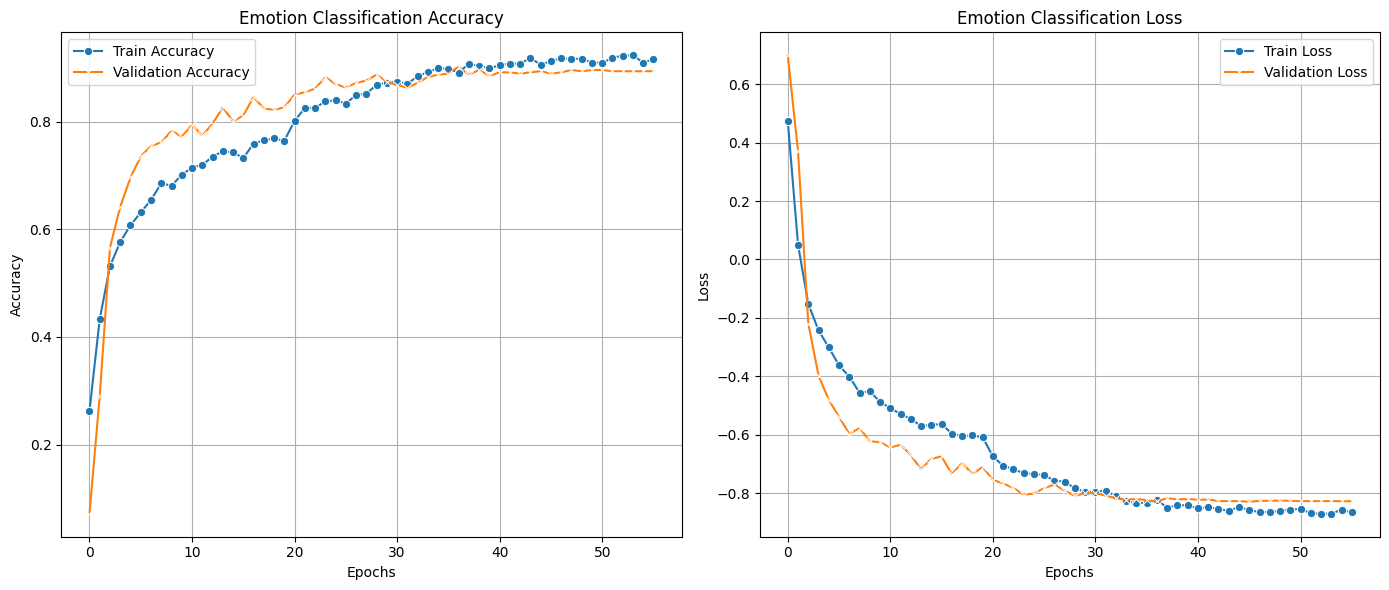

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


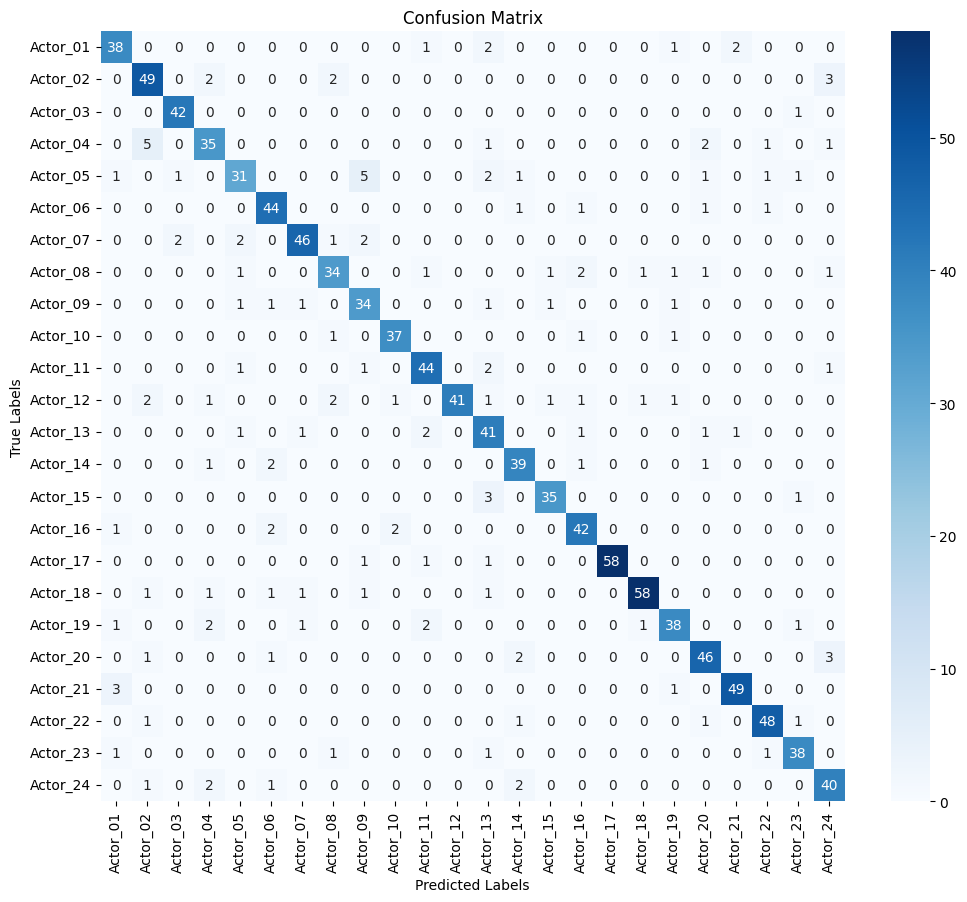

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


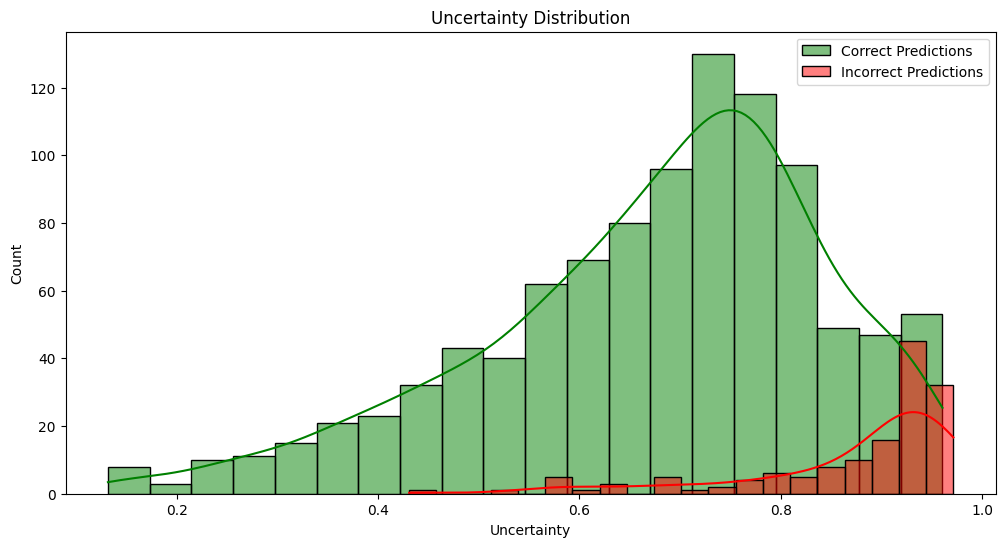

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


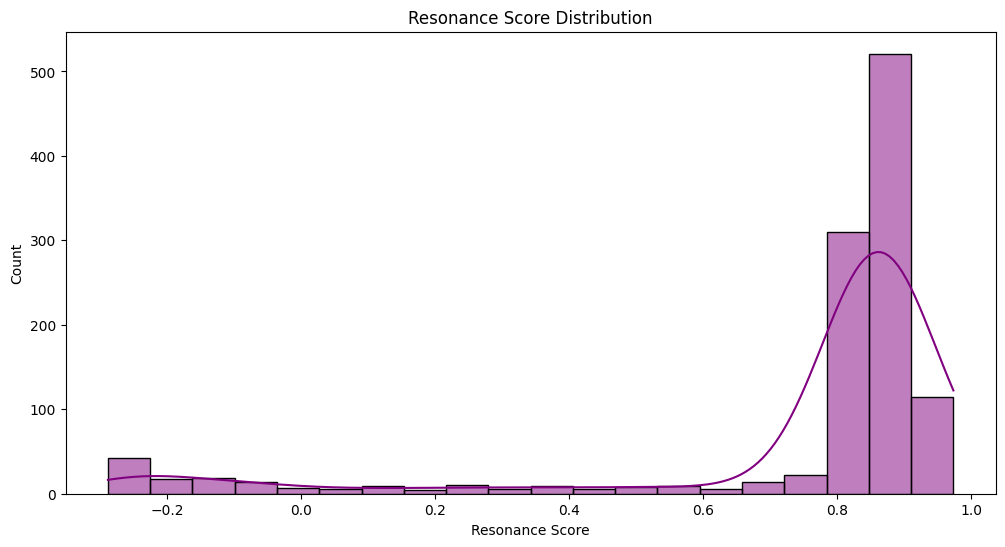

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


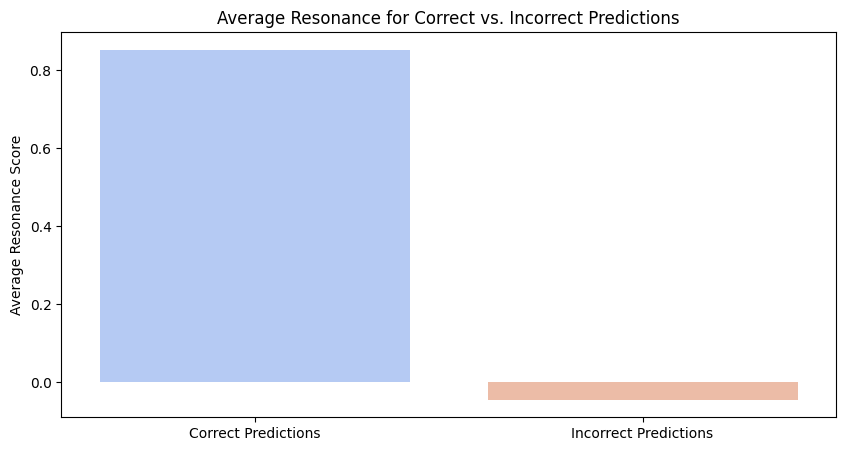

Average Resonance for Correct Predictions: 0.8526
Average Resonance for Incorrect Predictions: -0.0446


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Enhanced Training History Visualization ---
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=range(len(history.history['emotion_output_accuracy'])), y=history.history['emotion_output_accuracy'], label='Train Accuracy', marker='o')
sns.lineplot(x=range(len(history.history['val_emotion_output_accuracy'])), y=history.history['val_emotion_output_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Emotion Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=range(len(history.history['emotion_output_loss'])), y=history.history['emotion_output_loss'], label='Train Loss', marker='o')
sns.lineplot(x=range(len(history.history['val_emotion_output_loss'])), y=history.history['val_emotion_output_loss'], label='Validation Loss', marker='x')
plt.title('Emotion Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('enhanced_training_history.png')
plt.show()

# --- Confusion Matrix Visualization ---
y_pred = cr_model.predict([X_test, context_test])[0]
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('enhanced_confusion_matrix.png')
plt.show()

# --- Uncertainty Distribution ---
plt.figure(figsize=(12, 6))
all_uncertainties = cr_model.predict([X_test, context_test])[1].flatten()
correct = (y_pred_classes == y_test)

sns.histplot(all_uncertainties[correct], color='green', bins=20, label='Correct Predictions', kde=True)
sns.histplot(all_uncertainties[~correct], color='red', bins=20, label='Incorrect Predictions', kde=True)
plt.title('Uncertainty Distribution')
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.legend()
plt.savefig('enhanced_uncertainty_distribution.png')
plt.show()

# --- Resonance Analysis ---
test_predictions, test_uncertainties = cr_model.predict([X_test, context_test])
resonance_scores = [
    resonance_mapping(np.eye(num_classes)[y_test[i]], test_predictions[i], uncertainty=test_uncertainties[i][0])
    for i in range(len(X_test))
]

# Resonance Distribution
plt.figure(figsize=(12, 6))
sns.histplot(resonance_scores, bins=20, color='purple', kde=True)
plt.title('Resonance Score Distribution')
plt.xlabel('Resonance Score')
plt.ylabel('Count')
plt.savefig('enhanced_resonance_distribution.png')
plt.show()

# Resonance vs. Accuracy
correct_indices = np.where(y_pred_classes == y_test)[0]
incorrect_indices = np.where(y_pred_classes != y_test)[0]

avg_resonance_correct = np.mean([resonance_scores[i] for i in correct_indices])
avg_resonance_incorrect = np.mean([resonance_scores[i] for i in incorrect_indices])

plt.figure(figsize=(10, 5))
sns.barplot(x=['Correct Predictions', 'Incorrect Predictions'], y=[avg_resonance_correct, avg_resonance_incorrect], palette='coolwarm')
plt.title('Average Resonance for Correct vs. Incorrect Predictions')
plt.ylabel('Average Resonance Score')
plt.savefig('resonance_vs_accuracy.png')
plt.show()

print(f"Average Resonance for Correct Predictions: {avg_resonance_correct:.4f}")
print(f"Average Resonance for Incorrect Predictions: {avg_resonance_incorrect:.4f}")


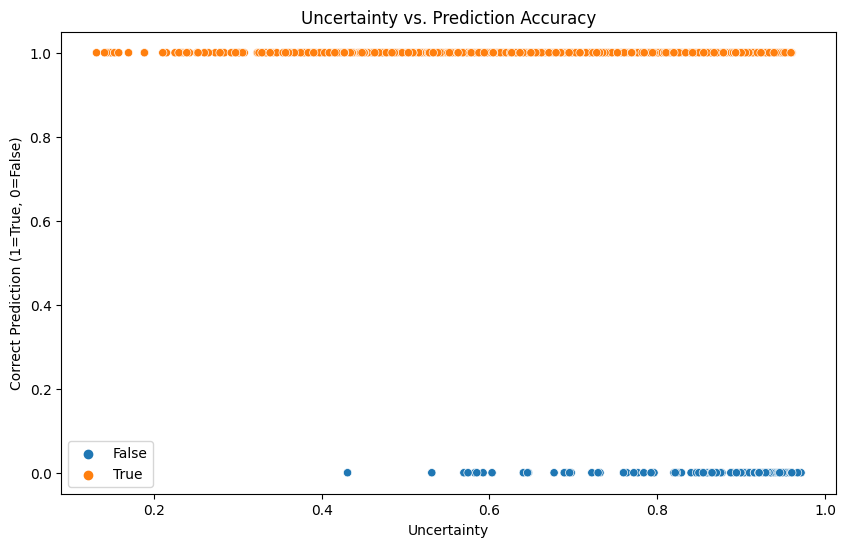

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_uncertainties, y=(y_pred_classes == y_test), hue=(y_pred_classes == y_test))
plt.title('Uncertainty vs. Prediction Accuracy')
plt.xlabel('Uncertainty')
plt.ylabel('Correct Prediction (1=True, 0=False)')
plt.show()


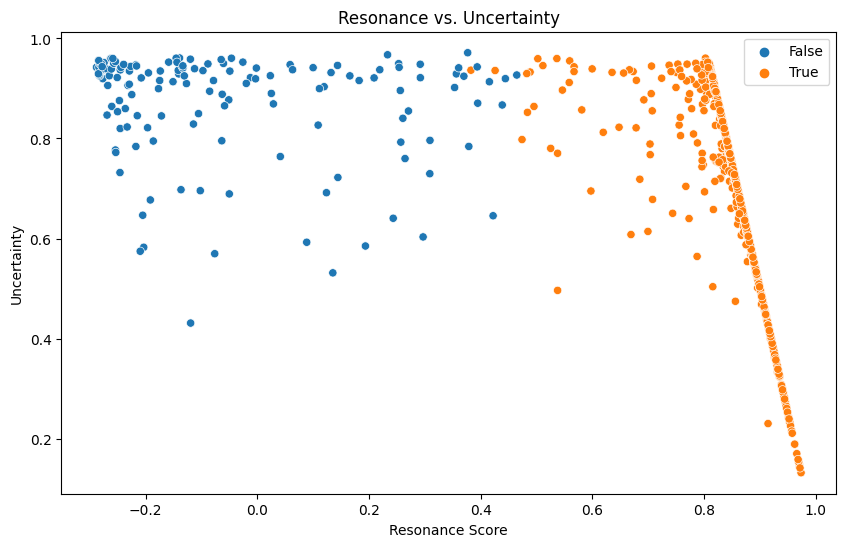

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=resonance_scores, y=all_uncertainties, hue=(y_pred_classes == y_test))
plt.title('Resonance vs. Uncertainty')
plt.xlabel('Resonance Score')
plt.ylabel('Uncertainty')
plt.show()


In [18]:
# --- SAVE MODEL AND RESULTS ---
# Save the trained model
cr_model.save('cognitive_resonance_model.h5')

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Save transition matrix
with open('transition_matrix.pkl', 'wb') as f:
    pickle.dump(transition_matrix, f)

# Save feedback history
with open('feedback_history.pkl', 'wb') as f:
    pickle.dump(feedback_callback.history, f)

print("\nModel, label encoder, transition matrix, and feedback history saved successfully!")


Model, label encoder, transition matrix, and feedback history saved successfully!
